<a href="https://colab.research.google.com/github/jessy-suresh/PRACTICE-QUESTIONS-MACHINE-LEARNING/blob/main/support_vector_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
import cvxopt  # For quadratic programming

class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        # Convert labels to -1, 1
        y_ = np.where(y <= 0, -1, 1)
        n_samples, n_features = X.shape

        # Initialize weights and bias
        self.w = np.zeros(n_features)
        self.b = 0

        # Gradient descent
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1

                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        linear_output = np.dot(X, self.w) - self.b
        return np.sign(linear_output)

In [2]:
class SVMQP:
    """SVM using Quadratic Programming (Dual Form)"""

    def __init__(self, kernel='linear', C=1.0, gamma=1.0):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.alpha = None
        self.b = None
        self.X_train = None
        self.y_train = None
        self.support_vectors = None
        self.support_vector_labels = None

    def _linear_kernel(self, X1, X2):
        return np.dot(X1, X2.T)

    def _rbf_kernel(self, X1, X2):
        if X1.ndim == 1 and X2.ndim == 1:
            return np.exp(-self.gamma * np.linalg.norm(X1 - X2)**2)
        elif X1.ndim == 1:
            return np.exp(-self.gamma * np.linalg.norm(X1 - X2, axis=1)**2)
        elif X2.ndim == 1:
            return np.exp(-self.gamma * np.linalg.norm(X1 - X2, axis=1)**2)
        else:
            return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2)**2)

    def _polynomial_kernel(self, X1, X2, degree=3):
        return (1 + np.dot(X1, X2.T)) ** degree

    def _get_kernel(self, X1, X2):
        if self.kernel == 'linear':
            return self._linear_kernel(X1, X2)
        elif self.kernel == 'rbf':
            return self._rbf_kernel(X1, X2)
        elif self.kernel == 'poly':
            return self._polynomial_kernel(X1, X2)
        else:
            raise ValueError("Unsupported kernel")

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Convert labels to -1, 1
        y_ = np.where(y <= 0, -1, 1)

        # Kernel matrix
        K = self._get_kernel(X, X)

        # Solve quadratic programming problem
        # min 1/2 * alpha^T * P * alpha - q^T * alpha
        # subject to 0 <= alpha_i <= C and sum(alpha_i * y_i) = 0

        P = cvxopt.matrix(np.outer(y_, y_) * K)
        q = cvxopt.matrix(-np.ones(n_samples))

        # Constraints: 0 <= alpha_i <= C
        G = cvxopt.matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

        # Equality constraint: sum(alpha_i * y_i) = 0
        A = cvxopt.matrix(y_, (1, n_samples), 'd')
        b = cvxopt.matrix(0.0)

        # Solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        alpha = np.ravel(solution['x'])

        # Support vectors
        sv = alpha > 1e-5
        self.alpha = alpha[sv]
        self.support_vectors = X[sv]
        self.support_vector_labels = y_[sv]

        # Calculate bias
        self.b = 0
        for i in range(len(self.alpha)):
            self.b += self.support_vector_labels[i]
            self.b -= np.sum(self.alpha * self.support_vector_labels *
                           self._get_kernel(self.support_vectors[i], self.support_vectors))
        self.b /= len(self.alpha)

        self.X_train = X
        self.y_train = y_

    def predict(self, X):
        if self.alpha is None:
            raise ValueError("Model must be fitted first")

        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            s = 0
            for alpha, sv_y, sv in zip(self.alpha, self.support_vector_labels, self.support_vectors):
                s += alpha * sv_y * self._get_kernel(X[i], sv)
            y_pred[i] = s

        return np.sign(y_pred + self.b)

    def get_params(self):
        return {
            'n_support_vectors': len(self.support_vectors) if self.support_vectors is not None else 0,
            'bias': self.b,
            'alphas': self.alpha
        }

In [3]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def sklearn_svm_example():
    """Complete SVM example using scikit-learn"""

    # Generate sample data
    X, y = make_blobs(n_samples=300, centers=2, random_state=42, cluster_std=1.5)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train different SVM models
    models = {
        'Linear SVM': SVC(kernel='linear', C=1.0),
        'RBF SVM': SVC(kernel='rbf', C=1.0, gamma='scale'),
        'Polynomial SVM': SVC(kernel='poly', degree=3, C=1.0)
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'predictions': y_pred
        }
        print(f"{name} Accuracy: {accuracy:.3f}")

    return results, X_train_scaled, y_train, X_test_scaled, y_test

# Run sklearn example
print("=== Scikit-learn SVM Example ===")
results, X_train, y_train, X_test, y_test = sklearn_svm_example()

=== Scikit-learn SVM Example ===
Linear SVM Accuracy: 1.000
RBF SVM Accuracy: 1.000
Polynomial SVM Accuracy: 0.989



=== Advanced SVM with Different Kernels ===
LINEAR Kernel SVM Accuracy: 0.667


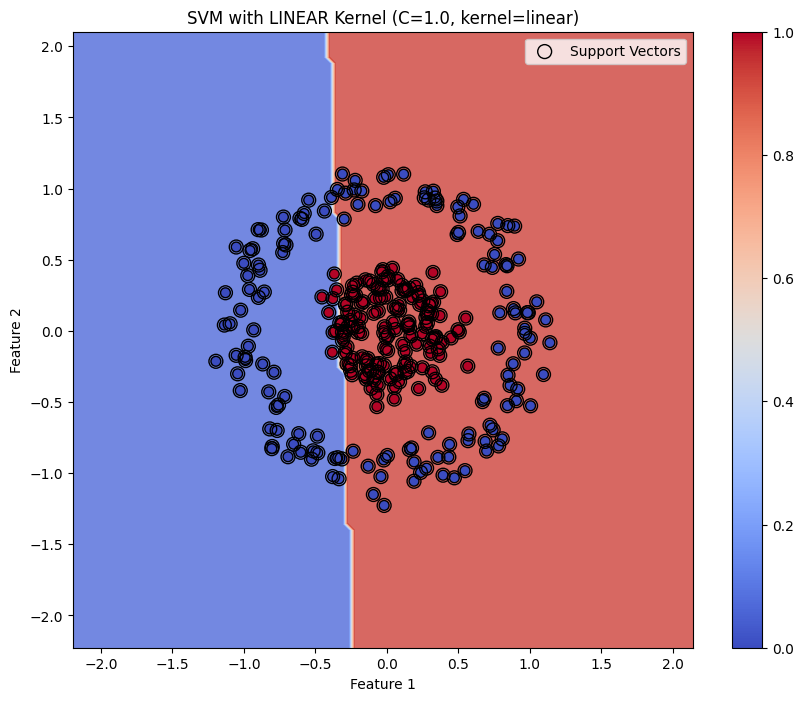

Number of support vectors: 300
RBF Kernel SVM Accuracy: 1.000


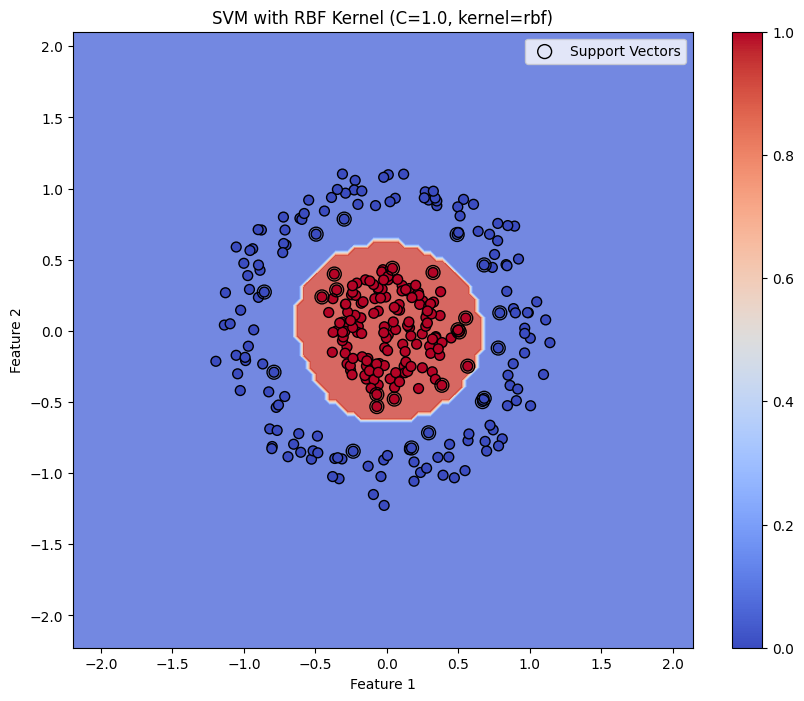

Number of support vectors: 26
POLY Kernel SVM Accuracy: 0.673


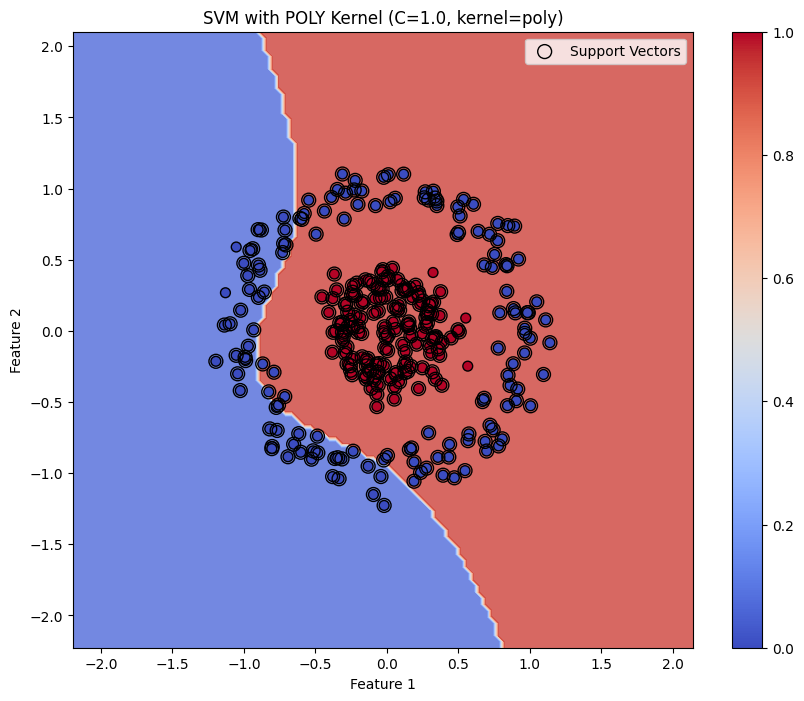

Number of support vectors: 295


In [4]:
class AdvancedSVM:
    """Advanced SVM with custom kernels and visualization"""

    def __init__(self, C=1.0, kernel='rbf', gamma=1.0, degree=3):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.model = None

    def fit(self, X, y):
        self.model = SVC(
            C=self.C,
            kernel=self.kernel,
            gamma=self.gamma,
            degree=self.degree,
            probability=True
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def decision_function(self, X):
        return self.model.decision_function(X)

    def plot_decision_boundary(self, X, y, title="SVM Decision Boundary"):
        """Plot decision boundary with support vectors"""

        # Create mesh grid
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))

        # Predict on mesh grid
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot
        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
        scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='black',
                             cmap=plt.cm.coolwarm, s=50)

        # Plot support vectors
        if hasattr(self.model, 'support_vectors_'):
            plt.scatter(self.model.support_vectors_[:, 0],
                       self.model.support_vectors_[:, 1],
                       s=100, facecolors='none', edgecolors='black',
                       linewidths=1, label='Support Vectors')
            plt.legend()

        plt.colorbar(scatter)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title(f'{title} (C={self.C}, kernel={self.kernel})')
        plt.show()

    def get_support_vectors_info(self):
        """Get information about support vectors"""
        if self.model is None:
            return "Model not fitted"

        info = {
            'n_support_vectors': len(self.model.support_vectors_),
            'support_vectors': self.model.support_vectors_,
            'dual_coef': self.model.dual_coef_,
            'intercept': self.model.intercept_
        }
        return info

# Test advanced SVM
def test_advanced_svm():
    # Generate non-linear data
    X, y = make_circles(n_samples=300, noise=0.1, factor=0.3, random_state=42)

    # Train with different kernels
    kernels = ['linear', 'rbf', 'poly']

    for kernel in kernels:
        svm = AdvancedSVM(C=1.0, kernel=kernel, gamma=2.0)
        svm.fit(X, y)

        accuracy = accuracy_score(y, svm.predict(X))
        print(f"{kernel.upper()} Kernel SVM Accuracy: {accuracy:.3f}")

        svm.plot_decision_boundary(X, y, f"SVM with {kernel.upper()} Kernel")

        info = svm.get_support_vectors_info()
        print(f"Number of support vectors: {info['n_support_vectors']}")

print("\n=== Advanced SVM with Different Kernels ===")
test_advanced_svm()


=== SVM Hyperparameter Tuning ===
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Best cross-validation score: 1.0
Test accuracy: 1.000


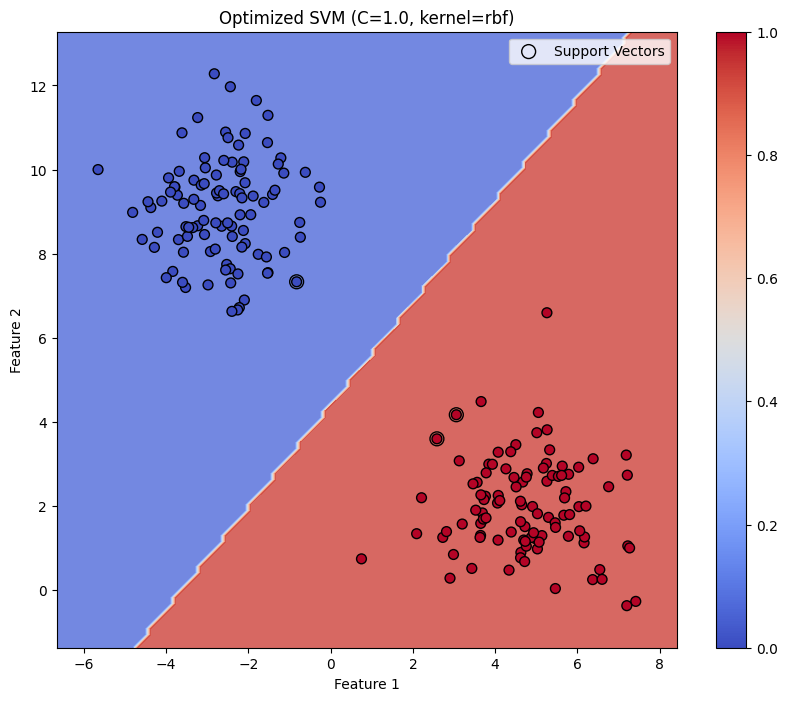

In [5]:
def svm_hyperparameter_tuning():
    """SVM with hyperparameter tuning using GridSearch"""

    # Generate data
    X, y = make_blobs(n_samples=200, centers=2, random_state=42, cluster_std=1.2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'linear', 'poly']
    }

    # Grid search
    grid = GridSearchCV(
        SVC(),
        param_grid,
        refit=True,
        verbose=1,
        cv=5,
        scoring='accuracy'
    )

    grid.fit(X_train, y_train)

    print("Best parameters:", grid.best_params_)
    print("Best cross-validation score:", grid.best_score_)

    # Evaluate on test set
    y_pred = grid.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {test_accuracy:.3f}")

    # Plot results
    best_model = grid.best_estimator_
    advanced_svm = AdvancedSVM()
    advanced_svm.model = best_model
    advanced_svm.plot_decision_boundary(X, y, "Optimized SVM")

    return grid

print("\n=== SVM Hyperparameter Tuning ===")
tuned_svm = svm_hyperparameter_tuning()


=== Multi-class SVM ===
One-vs-Rest Accuracy: 0.922
One-vs-One Accuracy: 0.922


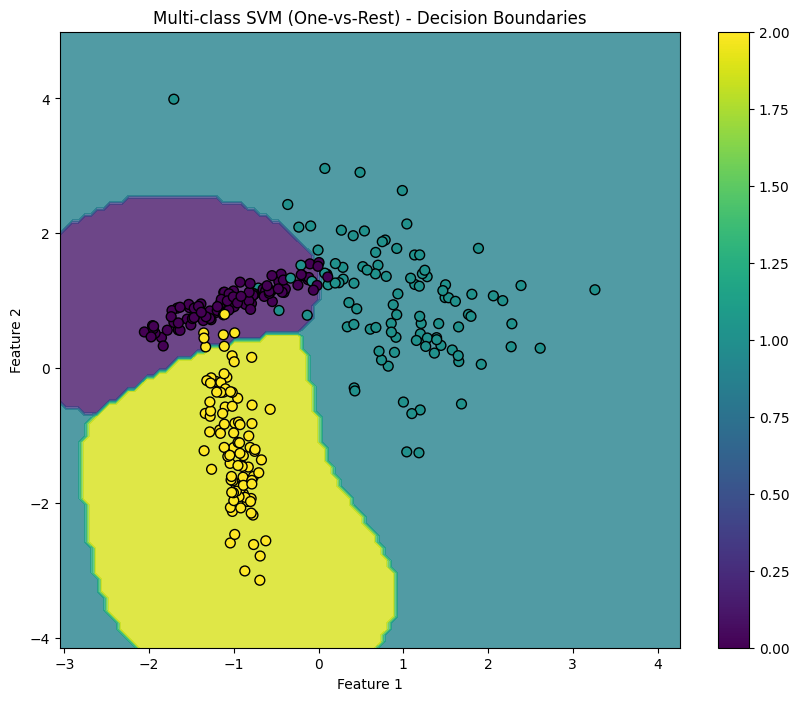

In [6]:
def multiclass_svm_example():
    """SVM for multi-class classification"""

    from sklearn.datasets import make_classification
    from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

    # Generate multi-class data
    X, y = make_classification(
        n_samples=300, n_features=2, n_informative=2, n_redundant=0,
        n_classes=3, n_clusters_per_class=1, random_state=42
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Different multi-class strategies
    strategies = {
        'One-vs-Rest': OneVsRestClassifier(SVC(kernel='rbf', C=1.0, probability=True)),
        'One-vs-One': OneVsOneClassifier(SVC(kernel='rbf', C=1.0, probability=True))
    }

    results = {}
    for strategy_name, classifier in strategies.items():
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        results[strategy_name] = {
            'classifier': classifier,
            'accuracy': accuracy,
            'predictions': y_pred
        }

        print(f"{strategy_name} Accuracy: {accuracy:.3f}")

    # Plot decision boundaries for best strategy
    best_strategy = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_classifier = results[best_strategy]['classifier']

    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Predict
    Z = best_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.viridis)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='black',
                         cmap=plt.cm.viridis, s=50)
    plt.colorbar(scatter)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Multi-class SVM ({best_strategy}) - Decision Boundaries')
    plt.show()

    return results

print("\n=== Multi-class SVM ===")
multiclass_results = multiclass_svm_example()